In [6]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
import kwant
%matplotlib inline

In [111]:
t = 1.0

def make_system(a=1, t=1.0, W=2, L=10):
    # Start with an empty tight-binding system and a single square lattice.
    # `a` is the lattice constant (by default set to 1 for simplicity.
    lat = kwant.lattice.square(a)

    syst = kwant.Builder()
    syst[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t
    syst[lat.neighbors()] = -t
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, j) for j in range(W))] = 4 * t
    lead[lat.neighbors()] = -t
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    return syst

syst = make_system()
syst = syst.finalized()
print(syst.leads[0].hamiltonian_submatrix())
syst.leads[1].modes(2.0)[0].wave_functions

[[ 4.+0.j -1.-0.j -1.-0.j  0.+0.j]
 [-1.+0.j  4.+0.j  0.+0.j -1.-0.j]
 [-1.+0.j  0.+0.j  4.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  4.+0.j]]


array([[-0.51897742-0.13905958j, -0.51897742+0.13905958j],
       [-0.51897742-0.13905958j, -0.51897742+0.13905958j]])

In [120]:
# define the parameters for the system

E = 2.0
t = -1.0
v = 4.0
N = 2
M = 10

# set up the lead matrix  
H = np.diag(v * np.ones(N) - E) + np.diag(t * np.ones(N - 1), k=1) + np.diag(t * np.ones(N - 1), k = -1)
I = np.diag(np.ones(N))
V = np.diag(t * np.ones(N))
Null = np.zeros((N, N))
A = np.stack((np.stack((Null, I), axis=1), np.stack((V, H), axis=1))).reshape(2*N, 2*N)
B = np.stack((np.stack((-I, Null), axis=1), np.stack((Null, V), axis=1))).reshape(2*N, 2*N)
print(A)

[[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-1.  0.  2. -1.]
 [ 0. -1. -1.  2.]]


In [142]:
# diagonalize the lead matrix
w, v = eig(A, B)
for i in range(w.shape[0]):
    m = v[:N, i]
    m /= np.sqrt(np.abs(2 * np.vdot(m.conjugate(), np.matmul(V, m / w[i])).imag))
    print(m)
    print(2 * np.vdot(m.conjugate(), np.matmul(V, m / w[i])).imag)

[ inf+nanj -inf+nanj]
nan
[0.5653485-0.04438348j 0.5653485-0.04438348j]
0.9999999999999999
[0.5653485+0.04438348j 0.5653485+0.04438348j]
-0.9999999999999999
[-inf+nanj  inf+nanj]
nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [114]:
# order the modes based on propagating, left/right moving
modes = [vec[:N] for vec in v.T]

modes_mat = np.vstack((modes[0], modes[1]))
for m in modes[2:]:
    modes_mat = np.vstack((modes_mat, m))

orthog_modes = []

for i in range(len(modes)):
    b = np.zeros(len(modes))
    b[i] = 1.
    orthog_modes.append(np.linalg.lstsq(modes_mat, b)[0])
        
self_energy_left = 0.
self_energy_right = 0.
V_L = np.diag(t * np.ones(N))
V_R = np.diag(t * np.ones(N))

org_modes = {'evan_R': [], 'evan_L': [], 'prop_R': [], 'prop_L': []}
org_eigs = {'evan_R': [], 'evan_L': [], 'prop_R': [], 'prop_L': []}
for e, m in zip(w, modes):
    current = 2 * (m.conjugate().dot(V_L.dot(e * m))).imag
    print(current)
    if np.abs(np.absolute(e) - 1) < 1e-8 :
        if current < 0:
            org_modes['prop_R'].append(m)
            org_eigs['prop_R'].append(e)
        else:
            org_modes['prop_L'].append(m)
            org_eigs['prop_L'].append(e)
    else:
        if current < 0:
            org_modes['evan_L'].append(m)
            org_eigs['even_L'].append(e)
        else:
            org_modes['evan_R'].append(m)
            org_eigs['evan_R'].append(e)
            
print(org_modes['prop_R'])
    
for w, m in zip(org_eigs['prop_R'], org_modes['prop_R']):
    self_energy_left += w**(-1) * np.outer(m, m.conjugate())    
for w, m in zip(org_eigs['evan_R'], org_modes['evan_R']):
    self_energy_left += w**(-1) * np.outer(m, m.conjugate())  
    
for w, m in zip(org_eigs['prop_L'], org_modes['prop_L']):
    self_energy_right += w * np.outer(m, m.conjugate())
for w, m in zip(org_eigs['evan_L'], org_modes['evan_L']):
    self_energy_right += w * np.outer(m, m.conjugate())    

self_energy_left *= V_L
self_energy_right *= V_R

0.0
-1.7320508075688779
1.7320508075688779
0.0
[array([0.70493776-0.05534214j, 0.70493776-0.05534214j])]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


0 1 Before: (10, 10)
After: (20, 10)
1 1 Before: (10, 10)
After: (20, 10)


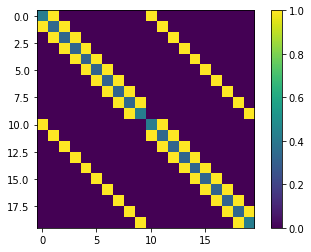

In [73]:
rows = [None] * M

for i in range(M):
    if i == 0:
        rows[i] = H + self_energy_left
    elif i == 1:
        rows[i] = V
    else:
        rows[i] = Null
    
for i in range(M):
    for j in range(1,M):
        print(i,j, 'Before:', rows[i].shape)
        if i == j:
            if j == M - 1:
                rows[i] = np.stack((rows[i], H + self_energy_right), axis=1).reshape((j + 1)*N, N)
            else:
                rows[i] = np.stack((rows[i], H), axis=1).reshape((j + 1)*N, N)
        if i == j - 1 or i == j + 1:
            rows[i] = np.stack((rows[i], V), axis=1).reshape((j + 1)*N, N)
        print('After:', rows[i].shape)

total_H = np.stack((rows[0], rows[1])).reshape(N*M ,N*M)
plt.imshow(np.absolute(total_H))
plt.colorbar()
psi = np.linalg.solve(total_H, np.ones(2 * N))

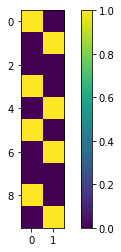

In [42]:
psi_squ = np.absolute(psi.reshape((N,M)))**2
plt.imshow(psi_squ)
plt.colorbar()